In [17]:
import json

import numpy as np
import torch
from torchvision import models

import shap
from torchvision import datasets, transforms, models

from torch.utils.data import random_split, DataLoader, Subset


In [2]:
val_transform = transforms.Compose([
    transforms.Resize(540),         # 짧은 변을 540으로
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

# data_root = '/home/work/workspace_ai/Artificlass/data_process/data/augmented_images_4'
# full_dataset = datasets.ImageFolder(root=data_root, transform=None)
# # train_ds = ImageFolder(root=data_root, transform=train_transform)
# # val_ds   = ImageFolder(root=data_root, transform=val_transform)
# style2idx   = full_dataset.class_to_idx.copy()
# num_classes = len(style2idx)

In [3]:
train_root='/home/work/workspace_ai/Artificlass/data_process/data/augmented_images_split/train'
val_root='/home/work/workspace_ai/Artificlass/data_process/data/augmented_images_split/val'
test_root='/home/work/workspace_ai/Artificlass/data_process/data/augmented_images_split/test'
# full_ds = datasets.ImageFolder(root=train_root, transform=None)
# val_full=datasets.ImageFolder(root=val_root, transform=None)
# style2idx = full_ds.class_to_idx.copy()
# num_classes = len(style2idx)
num_classes=7

In [5]:

# train_ds = datasets.ImageFolder(root=train_root, transform=train_transform)
val_ds   = datasets.ImageFolder(root=val_root,   transform=val_transform)
test_ds  = datasets.ImageFolder(root=test_root,  transform=val_transform)

loader_kwargs = dict(
    batch_size=32,
    num_workers=6,
    pin_memory=True,
    prefetch_factor=2,
    persistent_workers=True
)

# train_loader = DataLoader(train_ds, shuffle=True,  **loader_kwargs)
val_loader   = DataLoader(val_ds,   shuffle=False, **loader_kwargs)
test_loader  = DataLoader(test_ds,  shuffle=False, **loader_kwargs)


In [20]:
n = len(full_dataset)
indices = np.arange(n)
np.random.seed(seed=42)
np.random.shuffle(indices)

n_train = int(0.8 * n)
n_val   = int(0.1 * n)
train_idx = indices[:n_train]
val_idx   = indices[n_train:n_train+n_val]
test_idx  = indices[n_train+n_val:]

test_ds  = Subset(datasets.ImageFolder(root=data_root, transform=val_transform),
                  test_idx)

In [21]:
loader_kwargs = dict(
    batch_size=16,
    num_workers=4,
    pin_memory=True,
    prefetch_factor=2,
    persistent_workers=True
)

test_loader  = DataLoader(test_ds,  shuffle=False, **loader_kwargs)


In [6]:
import torch.nn as nn

class ResNet50Head(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        backbone = models.resnet50(pretrained=False)
        in_feats  = backbone.fc.in_features
        backbone.fc = nn.Identity()
        self.backbone = backbone

        self.drop = nn.Dropout(0.2)
        self.fc1  = nn.Linear(in_feats, 512)
        self.relu = nn.ReLU(inplace=True)
        self.fc2  = nn.Linear(512, 128)
        self.fc3  = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.backbone(x)        # → (batch, 2048)
        x = self.drop(x)
        x = self.relu(self.fc1(x))  # → (batch, 1024)
        x = self.drop(x)
        x = self.relu(self.fc2(x))
        x = self.drop(x)
        x = self.fc3(x)             # → (batch, num_classes)
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model  = ResNet50Head(num_classes).to(device)

The parameter 'pretrained' is deprecated, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated. The current behavior is equivalent to passing `weights=None`.


In [7]:
# Model load 

model_path='/home/work/workspace_ai/Artificlass/real_use_code/best_model_from_folder_pre.pth'
model.load_state_dict(torch.load(model_path))
model.eval()

ResNet50Head(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

In [13]:
import os
import json
import numpy as np
import torch
from torchvision import models
from PIL import Image
import shap
import torch.nn.functional as F


# 1) 모델 불러오기
from backbone import ResNet50Head  # 실제 정의한 모듈 경로 맞춰주세요
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# data_root = '/home/work/workspace_ai/Artificlass/data_process/data/augmented_images_4'
# full_dataset = datasets.ImageFolder(root=data_root, transform=None)
# # train_ds = ImageFolder(root=data_root, transform=train_transform)
# # val_ds   = ImageFolder(root=data_root, transform=val_transform)
# style2idx   = full_dataset.class_to_idx.copy()
style2idx = {'Art Nouveau': 0, 'Baroque': 1, 'Expressionism': 2, 'Impressionism': 3, 'Post-Impressionism': 4, 'Realism': 5, 'Romantic': 6}
idx2style = {i:s for s,i in style2idx.items()}
num_classes = len(style2idx)
model = ResNet50Head(num_classes).to(device)
# model=EfficientNetB0Head(num_classes).to(device)
model.load_state_dict(torch.load('/home/work/workspace_ai/Artificlass/weights/Real/best_model_from_folder_4.pth', map_location=device))
# model.load_state_dict(torch.load('/home/work/workspace_ai/Artificlass/weights/Real/best_model_efficientnet_b0_fixed.pth', map_location=device))
model.eval()

# 2) SHAP 입력용 normalize 함수
mean = np.array([0.485, 0.456, 0.406]).reshape((1,1,3))
std  = np.array([0.229, 0.224, 0.225]).reshape((1,1,3))
def preprocess(imgs):
    # imgs: numpy (B,H,W,3) in [0,1] or [0,255]
    if imgs.max() > 1.0:
        imgs = imgs / 255.0
    imgs = (imgs - mean) / std
    # B,H,W,3 → B,3,H,W
    return torch.from_numpy(imgs).permute(0,3,1,2).float().to(device)

# 3) 배경용(Background) 데이터 샘플
#    전체 테스트셋에서 랜덤하게 50장 정도 뽑아서 numpy array로 준비
from torchvision.datasets import ImageFolder
from torchvision import transforms

val_tf = transforms.Compose([
    transforms.Resize(540),
    transforms.CenterCrop(512),
    transforms.ToTensor()  # → [0,1], C×H×W
])

ds = ImageFolder(root='/home/work/workspace_ai/Artificlass/data_process/data/augmented_images_split/test',
                 transform=val_tf)
# 뒤에서 numpy로 바꾸려면 tensor→numpy
bg_indices = np.random.choice(len(ds), size=50, replace=False)
bg_imgs = []
for idx in bg_indices:
    img, _ = ds[idx]                # img: Tensor(3,512,512)
    bg_imgs.append(img.permute(1,2,0).numpy())  # H×W×C
bg_imgs = np.stack(bg_imgs, axis=0)  # (50,H,W,C)

# 4) 설명할 샘플 선택 (예: 2장)
to_explain = []
true_idxs  = []
# 1000,5800 에서는 잘 함 
for idx in [1000, 5700]:
    img, label = ds[idx]
    to_explain.append(img.permute(1,2,0).numpy())
    true_idxs.append(label)
to_explain = np.stack(to_explain, axis=0)  # (2,H,W,C)
true_idxs  = np.array(true_idxs)

# 5) GradientExplainer 생성
#    두 번째 인자는 ‘모델-출력-전’ 레이어를 지정할 수도 있지만,
#    전체 모델에 대해 입력 그라디언트 기반 설명을 원하면 (model, model.backbone) 처럼 전달
explainer = shap.GradientExplainer(
    (model, model.backbone),       # 또는 (model, model.backbone.layer4)
    preprocess(bg_imgs)            # background as Tensor(50,3,512,512)
)

# 6) SHAP 값 계산
#    ranked_outputs=1 → 가장 높은 클래스에 대한 explanation
shap_values, indexes = explainer.shap_values(
    preprocess(to_explain),       # Tensor(2,3,512,512)
    ranked_outputs=1,
    nsamples=100                   # 조절 가능
)
# 7) 예측 확률 계산
with torch.no_grad():
    logits = model(preprocess(to_explain))      # (B, num_classes)
    probs  = F.softmax(logits, dim=1).cpu().numpy()

idx_np = indexes.cpu().numpy()  # shape (B, 2)


# idx_np = indexes.cpu().numpy()  # shape (B,1) or (B,K)
# index_names = np.array([
#     [ idx2style[int(i)] for i in idx_list ]
#     for idx_list in idx_np
# ])

# 8) 클래스 이름 + 확률 문구 생성
# index_names = np.array([
#     [ f"{idx2style[i]} ({probs[s, i]:.2%})" for i in idx_list ]
#     for s, idx_list in enumerate(idx_np)
# ])

index_names = np.array([
    [ 
      f"Actual:    {idx2style[true_idxs[s]]}\n"
      f"Predicted: {idx2style[int(idx_np[s,0])]} "
      f"({probs[s,int(idx_np[s,0])]:.2%})"
    ]
    for s in range(len(to_explain))
])

# 8) 시각화
#    shap_values: list of arrays [ for each output-class: (2,3,512,512) ]
#    to_explain:      (2,512,512,3)
#    index_names:     (2,1)
shap_values = [ sv.transpose(0,2,3,1) for sv in shap_values ]
shap.image_plot(shap_values, to_explain, index_names)


Arguments other than a weight enum or `None` for 'weights' are deprecated. The current behavior is equivalent to passing `weights=None`.


KeyboardInterrupt: 

# ROC curve

In [14]:
import os
import json
import numpy as np
import torch
from torchvision import models
from PIL import Image
import shap
import torch.nn.functional as F

The parameter 'pretrained' is deprecated, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.


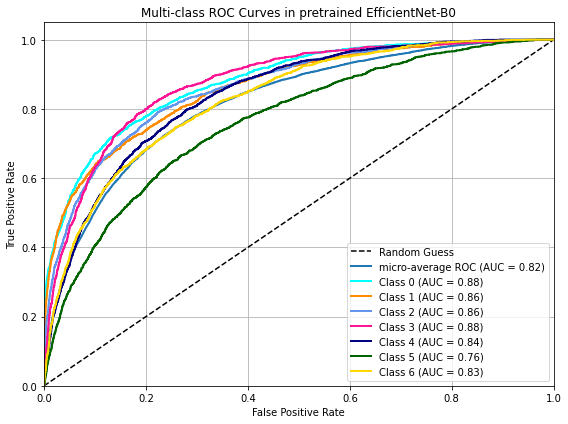

In [19]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from torchvision import datasets, transforms

import torch.nn as nn
# import torch.models as models


num_classes=7
# 1) 전체 Dataset 정의 (transform=val_tf)
# full_ds = ImageFolder(root=data_root, transform=val_transform)

# # 2) train/val/test split (seed=42)
# n = len(full_ds)
# indices = np.arange(n)
# np.random.seed(42)
# np.random.shuffle(indices)
# n_train = int(0.8 * n)
# n_val   = int(0.1 * n)
# train_idx = indices[:n_train]
# val_idx   = indices[n_train:n_train+n_val]
# test_idx  = indices[n_train+n_val:]

# # 3) 테스트 전용 Subset
# test_ds = Subset(full_ds, test_idx)
# test_loader = DataLoader(test_ds, shuffle=False, **loader_kwargs)
# num_classes = len(style2idx)
# model = ResNet50Head(num_classes).to(device)

val_transform = transforms.Compose([
    transforms.Resize(540),
    transforms.CenterCrop(512),
    transforms.ToTensor()  # → [0,1], C×H×W
])

class EfficientNetB0Head(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # ImageNet pretrained EfficientNet-B0 불러오기
        backbone = models.efficientnet_b0(pretrained=True)
        in_feats = backbone.classifier[1].in_features
        # 기존 classifier 제거
        backbone.classifier = nn.Identity()
        self.backbone = backbone

        # 새 분류기 추가
        self.drop = nn.Dropout(0.2)
        self.fc1  = nn.Linear(in_feats, 512)
        self.relu = nn.ReLU(inplace=True)
        self.fc2  = nn.Linear(512, 128)
        self.fc3  = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.backbone(x)          # → (batch, in_feats)
        x = self.drop(x)
        x = self.relu(self.fc1(x))    # → (batch, 512)
        x = self.drop(x)
        x = self.relu(self.fc2(x))    # → (batch, 128)
        x = self.drop(x)
        return self.fc3(x)            # → (batch, num_classes)

device='cuda'
model=EfficientNetB0Head(num_classes).to(device)
model.load_state_dict(torch.load('/home/work/workspace_ai/Artificlass/weights/Real/best_model_efficientnet_b0_fixed.pth', map_location=device))
model.eval()
# model.eval()


train_root='/home/work/workspace_ai/Artificlass/data_process/data/augmented_images_split/train'
val_root='/home/work/workspace_ai/Artificlass/data_process/data/augmented_images_split/val'
test_root='/home/work/workspace_ai/Artificlass/data_process/data/augmented_images_split/test'
num_classes=7


train_ds = datasets.ImageFolder(root=train_root, transform=val_transform)
val_ds   = datasets.ImageFolder(root=val_root,   transform=val_transform)
full_ds  = datasets.ImageFolder(root=test_root,  transform=val_transform)

loader_kwargs = dict(
    batch_size=16,
    num_workers=6,
    pin_memory=True,
    prefetch_factor=2,
    persistent_workers=True
)

train_loader = DataLoader(train_ds, shuffle=True,  **loader_kwargs)
val_loader   = DataLoader(val_ds,   shuffle=False, **loader_kwargs)
test_loader  = DataLoader(full_ds,  shuffle=False, **loader_kwargs)

# — 2) test set 전체에 대해 예측 확률과 실제 레이블 수집 —
y_true = []
y_score = []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        probs  = F.softmax(logits, dim=1).cpu().numpy()
        y_score.append(probs)
        y_true.append(labels.numpy())

y_score = np.vstack(y_score)   # shape (N_samples, N_classes)
y_true  = np.concatenate(y_true)  # shape (N_samples,)

# — 3) 레이블 이진화 (one-hot) —
n_classes = y_score.shape[1]
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))  # shape (N, n_classes)

# — 4) 클래스별 ROC / AUC 계산 —
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# — 5) Micro-average ROC —
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# — 6) Plotting —
plt.figure(figsize=(8, 6))
# 대각선 (무작위 분류기)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# micro-average
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC (AUC = {roc_auc["micro"]:.2f})',
         linewidth=2)

# 클래스별
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink', 'navy', 'darkgreen', 'gold'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curves in pretrained EfficientNet-B0')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


# Heatmap

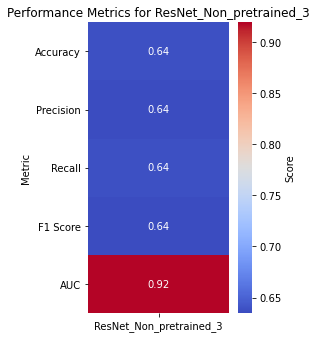

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

# ─────────────────────────────────────────────────────────────
# 0) 모델, test_loader, device 준비 (이미 정의된 변수)
# ─────────────────────────────────────────────────────────────\

# 1) 전체 Dataset 정의 (transform=val_tf)
# full_ds = ImageFolder(root=data_root, transform=val_transform)

# # 2) train/val/test split (seed=42)
# n = len(full_ds)
# indices = np.arange(n)
# np.random.seed(42)
# np.random.shuffle(indices)
# n_train = int(0.8 * n)
# n_val   = int(0.1 * n)
# train_idx = indices[:n_train]
# val_idx   = indices[n_train:n_train+n_val]
# test_idx  = indices[n_train+n_val:]

# # 3) 테스트 전용 Subset
# test_ds = Subset(full_ds, test_idx)
# test_loader = DataLoader(test_ds, shuffle=False, **loader_kwargs)
# num_classes = len(style2idx)
# model = ResNet50Head(num_classes).to(device)
# model.load_state_dict(torch.load('/home/work/workspace_ai/best_model_from_folder.pth', map_location=device))
# model.eval()
# model.eval()

# model: 학습된 ResNet50Head 등
# test_loader: DataLoader(test_ds, batch_size=..., shuffle=False)
# device: 'cuda' or 'cpu'
model.eval()

# ─────────────────────────────────────────────────────────────
# 1) test set 돌면서 y_true, y_pred, y_prob 수집
# ─────────────────────────────────────────────────────────────
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        probs  = F.softmax(logits, dim=1).cpu().numpy()
        preds  = np.argmax(probs, axis=1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds)
        y_prob.extend(probs)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.vstack(y_prob)  # shape (N_samples, num_classes)

# ─────────────────────────────────────────────────────────────
# 2) 주요 지표 계산 (macro average)
# ─────────────────────────────────────────────────────────────
acc   = accuracy_score(y_true, y_pred)
prec  = precision_score(y_true, y_pred, average='macro', zero_division=0)
rec   = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1    = f1_score(y_true, y_pred, average='macro', zero_division=0)
# 다중 클래스 AUC: OVR, macro
auc   = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')

metrics = {
    'Accuracy':  acc,
    'Precision': prec,
    'Recall':    rec,
    'F1 Score':  f1,
    'AUC':       auc
}

# ─────────────────────────────────────────────────────────────
# 3) DataFrame으로 변환 & 히트맵 그리기
# ─────────────────────────────────────────────────────────────
model_name = 'ResNet_Non_pretrained_3'  # 원하는 이름으로 바꿔 주세요

df = pd.DataFrame(metrics, index=[model_name]).T
#              MyModel
# Accuracy         0.89
# Precision        0.87
# ...

plt.figure(figsize=(4, 5))
sns.heatmap(
    df,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    cbar_kws={'label': 'Score'}
)
plt.title(f'Performance Metrics for {model_name}')
plt.ylabel('Metric')
plt.xlabel(' ')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


The parameter 'pretrained' is deprecated, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated. The current behavior is equivalent to passing `weights=None`.
The parameter 'pretrained' is deprecated, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated. The current behavior is equivalent to passing `weights=None`.
The parameter 'pretrained' is deprecated, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.


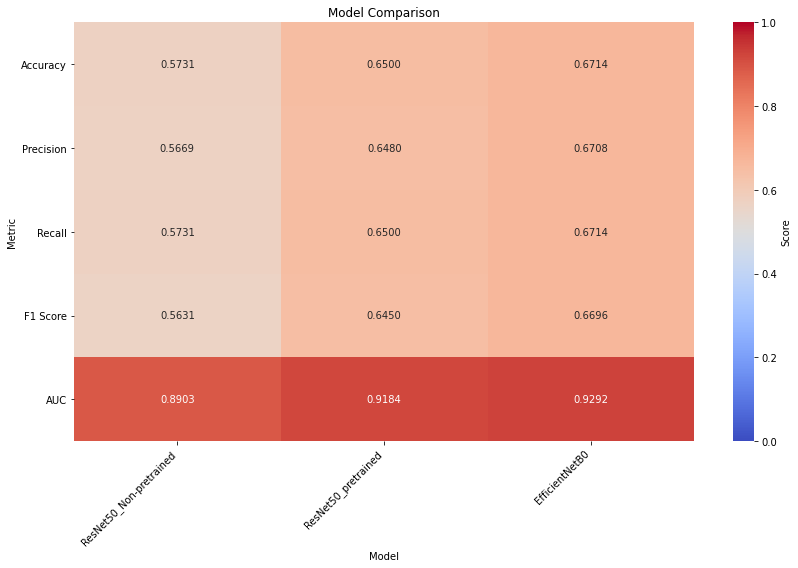

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from backbone import ResNet50Head
# from backbone import EfficientNetB0Head
# from efficientnet import EfficientNetB0Head

val_transform = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])
seed = 42


class EfficientNetB0Head(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # ImageNet pretrained EfficientNet-B0 불러오기
        backbone = models.efficientnet_b0(pretrained=True)
        in_feats = backbone.classifier[1].in_features
        # 기존 classifier 제거
        backbone.classifier = nn.Identity()
        self.backbone = backbone

        # 새 분류기 추가
        self.drop = nn.Dropout(0.2)
        self.fc1  = nn.Linear(in_feats, 512)
        self.relu = nn.ReLU(inplace=True)
        self.fc2  = nn.Linear(512, 128)
        self.fc3  = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.backbone(x)          # → (batch, in_feats)
        x = self.drop(x)
        x = self.relu(self.fc1(x))    # → (batch, 512)
        x = self.drop(x)
        x = self.relu(self.fc2(x))    # → (batch, 128)
        x = self.drop(x)
        return self.fc3(x)            # → (batch, num_classes)
    
class EfficientNetB2Head(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        backbone = models.efficientnet_b2(pretrained=True)
        feat = backbone.classifier[1].in_features
        backbone.classifier = nn.Identity()
        self.backbone = backbone
        self.drop = nn.Dropout(0.2)
        self.fc1 = nn.Linear(feat,512)
        self.fc2 = nn.Linear(512,128)
        self.fc3 = nn.Linear(128,num_classes)
    def forward(self,x):
        x = self.backbone(x)
        x = self.drop(x)
        x = torch.relu(self.fc1(x))
        x = self.drop(x)
        x = torch.relu(self.fc2(x))
        x = self.drop(x)
        return self.fc3(x)

class Res_conv(nn.Module):
    def __init__(self, num_classes=7):
        super(Res_conv, self).__init__()
        
        self.downsample = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=3, stride=2, padding=1),  # 512->256
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Conv2d(3, 3, kernel_size=3, stride=2, padding=1),  # 256->128
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False),
            nn.Conv2d(3, 3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU()
        )

        self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.backbone.fc = nn.Identity()  # Fully connected 제거

        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.downsample(x)
        x = self.backbone(x)
        x = self.classifier(x)
        return x
    
class EfficientNetB2Custom(nn.Module):
    def __init__(self, num_classes=7):
        super(EfficientNetB2Custom, self).__init__()
        self.downsample = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.backbone = models.efficientnet_b2(pretrained=False)
        self.backbone.features[0][0] = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False)

        self.backbone.classifier = nn.Sequential(  # Replace head
            nn.Dropout(0.3),
            nn.Linear(self.backbone.classifier[1].in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.downsample(x)
        x = self.backbone(x)
        return x
    


train_root='/home/work/workspace_ai/Artificlass/data_process/data/augmented_images_split_v2/train'
val_root='/home/work/workspace_ai/Artificlass/data_process/data/augmented_images_split_v2/val'
test_root='/home/work/workspace_ai/Artificlass/data_process/data/augmented_images_split_v2/test'
num_classes=7


train_ds = datasets.ImageFolder(root=train_root, transform=val_transform)
val_ds   = datasets.ImageFolder(root=val_root,   transform=val_transform)
full_ds  = datasets.ImageFolder(root=test_root,  transform=val_transform)

loader_kwargs = dict(
    batch_size=16,
    num_workers=6,
    pin_memory=True,
    prefetch_factor=2,
    persistent_workers=True
)

train_loader = DataLoader(train_ds, shuffle=True,  **loader_kwargs)
val_loader   = DataLoader(val_ds,   shuffle=False, **loader_kwargs)
test_loader  = DataLoader(full_ds,  shuffle=False, **loader_kwargs)


device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 2) 모델 정의 리스트
model_info = {
    'ResNet50_Non-pretrained':      {'cls': ResNet50Head,     'ckpt':'/home/work/workspace_ai/Artificlass/weights/Real/best_model_from_folder_4.pth'},
    'ResNet50_pretrained':{'cls': ResNet50Head,     'ckpt':'/home/work/workspace_ai/Artificlass/weights/Real/best_model_from_folder_pre_4_fixed.pth'},
    # 'ResNet50_conv': {'cls': Res_conv, 'ckpt': '/home/work/workspace_ai/Artificlass/weights/Real/best_model_512_conv.pth'}, 
    'EfficientNetB0': {'cls': EfficientNetB0Head, 'ckpt':'/home/work/workspace_ai/Artificlass/weights/Real/best_model_efficientnet_b0_fixed.pth' }, 
    # 'EfficientNetB2': {'cls': EfficientNetB2Head, 'ckpt':'/home/work/workspace_ai/Artificlass/weights/Real/best_b2_fixed.pth' },
    # 'EfficientNetB2Custom': {'cls': EfficientNetB2Custom, 'ckpt': '/home/work/workspace_ai/Artificlass/weights/Real/best_model_effi_retrain.pth'}
}

# 3) 모델별 성능 수집
all_metrics = {}
for name, info in model_info.items():
    # if info['cls'] == EfficientNetB2Head:
    #     model = info['cls'](num_classes=7).to(device)
    #     model=torch.compile(model, EfficientNetB2Head(num_classes=7).to(device))
    model = info['cls'](num_classes=len(full_ds.classes)).to(device)
    model.load_state_dict(torch.load(info['ckpt'], map_location=device))
    model.eval()

    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            logits = model(imgs)
            probs  = F.softmax(logits, dim=1).cpu().numpy()
            preds  = np.argmax(probs, axis=1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds)
            y_prob.extend(probs)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.vstack(y_prob)

    metrics = {
        'Accuracy':  accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Recall':    recall_score(y_true, y_pred, average='macro', zero_division=0),
        'F1 Score':  f1_score(y_true, y_pred, average='macro', zero_division=0),
        'AUC':       roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
    }
    all_metrics[name] = metrics

# # 4) 히트맵
# df = pd.DataFrame(all_metrics).T
# plt.figure(figsize=(6,4))
# sns.heatmap(df, annot=True, fmt='.2f', cmap='coolwarm', cbar_kws={'label':'Score'})
# plt.title('Model Comparison')
# plt.ylabel('Model')
# plt.xlabel('Metric')
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()

# 4) 히트맵 (축 바꿔서)
all_hyun=all_metrics
df = pd.DataFrame(all_metrics)   # index=Metric, columns=Model

plt.figure(figsize=(12,8))
sns.heatmap(
    df,
    annot=True,
    fmt='.4f',
    cmap='coolwarm',
    cbar_kws={'label':'Score'},
    vmin=0.0, vmax=1.0
)
plt.title('Model Comparison')
plt.xlabel('Model')    # x축: 모델
plt.ylabel('Metric')   # y축: 지표
plt.xticks(rotation=45, ha='right')  # 모델 이름 기울여서 보기
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



The parameter 'pretrained' is deprecated, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated. The current behavior is equivalent to passing `weights=None`.


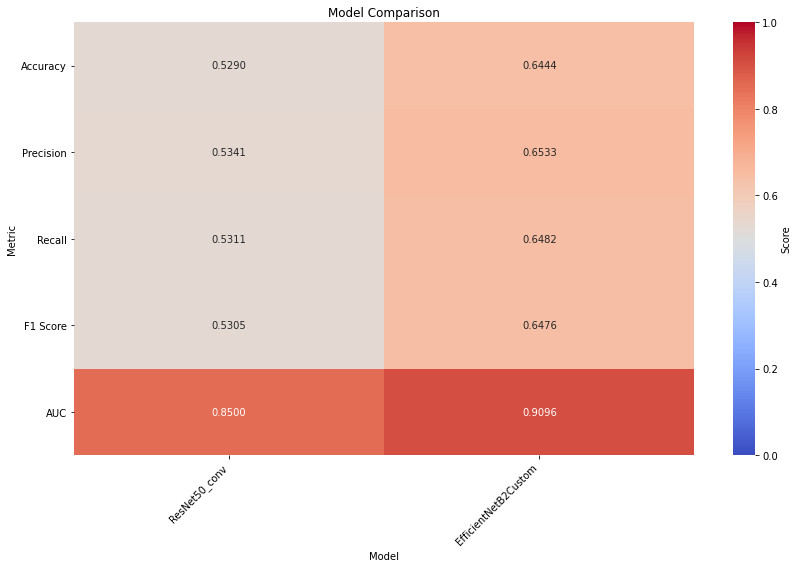

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from backbone import ResNet50Head
# from backbone import EfficientNetB0Head
# from efficientnet import EfficientNetB0Head

val_transform = transforms.Compose([
    transforms.Resize(512),
    # transforms.CenterCrop(512),
    transforms.ToTensor(),
    # transforms.Normalize(
    #     mean=[0.485, 0.456, 0.406],
    #     std =[0.229, 0.224, 0.225]
    # )
])
seed = 42


class EfficientNetB0Head(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # ImageNet pretrained EfficientNet-B0 불러오기
        backbone = models.efficientnet_b0(pretrained=True)
        in_feats = backbone.classifier[1].in_features
        # 기존 classifier 제거
        backbone.classifier = nn.Identity()
        self.backbone = backbone

        # 새 분류기 추가
        self.drop = nn.Dropout(0.2)
        self.fc1  = nn.Linear(in_feats, 512)
        self.relu = nn.ReLU(inplace=True)
        self.fc2  = nn.Linear(512, 128)
        self.fc3  = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.backbone(x)          # → (batch, in_feats)
        x = self.drop(x)
        x = self.relu(self.fc1(x))    # → (batch, 512)
        x = self.drop(x)
        x = self.relu(self.fc2(x))    # → (batch, 128)
        x = self.drop(x)
        return self.fc3(x)            # → (batch, num_classes)

class Res_conv(nn.Module):
    def __init__(self, num_classes=7):
        super(Res_conv, self).__init__()
        
        self.downsample = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=3, stride=2, padding=1),  # 512->256
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Conv2d(3, 3, kernel_size=3, stride=2, padding=1),  # 256->128
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False),
            nn.Conv2d(3, 3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU()
        )

        self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.backbone.fc = nn.Identity()  # Fully connected 제거

        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.downsample(x)
        x = self.backbone(x)
        x = self.classifier(x)
        return x
    
class EfficientNetB2Custom(nn.Module):
    def __init__(self, num_classes=7):
        super(EfficientNetB2Custom, self).__init__()
        self.downsample = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.backbone = models.efficientnet_b2(pretrained=False)
        self.backbone.features[0][0] = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False)

        self.backbone.classifier = nn.Sequential(  # Replace head
            nn.Dropout(0.3),
            nn.Linear(self.backbone.classifier[1].in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.downsample(x)
        x = self.backbone(x)
        return x
    


train_root='/home/work/workspace_ai/Artificlass/data_process/data/augmented_images_split_v2/train'
val_root='/home/work/workspace_ai/Artificlass/data_process/data/augmented_images_split_v2/val'
test_root='/home/work/workspace_ai/Artificlass/data_process/data/augmented_images_split/other_test'
num_classes=7


train_ds = datasets.ImageFolder(root=train_root, transform=val_transform)
val_ds   = datasets.ImageFolder(root=val_root,   transform=val_transform)
full_ds  = datasets.ImageFolder(root=test_root,  transform=val_transform)

loader_kwargs = dict(
    batch_size=16,
    num_workers=6,
    pin_memory=True,
    prefetch_factor=2,
    persistent_workers=True
)

train_loader = DataLoader(train_ds, shuffle=True,  **loader_kwargs)
val_loader   = DataLoader(val_ds,   shuffle=False, **loader_kwargs)
test_loader  = DataLoader(full_ds,  shuffle=False, **loader_kwargs)


device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 2) 모델 정의 리스트
model_info = {
    # 'ResNet50_Non-pretrained':      {'cls': ResNet50Head,     'ckpt':'/home/work/workspace_ai/Artificlass/weights/Real/best_model_from_folder_4.pth'},
    # 'ResNet50_pretrained':{'cls': ResNet50Head,     'ckpt':'/home/work/workspace_ai/Artificlass/weights/Real/best_model_from_folder_pre_4_fixed.pth'},
    'ResNet50_conv': {'cls': Res_conv, 'ckpt': '/home/work/workspace_ai/Artificlass/weights/Real/best_model_512_conv.pth'}, 
    # 'EfficientNetB2': {'cls': EfficientNetB0Head, 'ckpt':'/home/work/workspace_ai/Artificlass/weights/Real/best_model_efficientnet_b0_fixed.pth' }, 
    'EfficientNetB2Custom': {'cls': EfficientNetB2Custom, 'ckpt': '/home/work/workspace_ai/Artificlass/weights/Real/best_model_effi_retrain.pth'}
}

# 3) 모델별 성능 수집
all_metrics = {}
for name, info in model_info.items():
    model = info['cls'](num_classes=len(full_ds.classes)).to(device)
    model.load_state_dict(torch.load(info['ckpt'], map_location=device))
    model.eval()

    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            logits = model(imgs)
            probs  = F.softmax(logits, dim=1).cpu().numpy()
            preds  = np.argmax(probs, axis=1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds)
            y_prob.extend(probs)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.vstack(y_prob)

    metrics = {
        'Accuracy':  accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Recall':    recall_score(y_true, y_pred, average='macro', zero_division=0),
        'F1 Score':  f1_score(y_true, y_pred, average='macro', zero_division=0),
        'AUC':       roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
    }
    all_metrics[name] = metrics

# # 4) 히트맵
# df = pd.DataFrame(all_metrics).T
# plt.figure(figsize=(6,4))
# sns.heatmap(df, annot=True, fmt='.2f', cmap='coolwarm', cbar_kws={'label':'Score'})
# plt.title('Model Comparison')
# plt.ylabel('Model')
# plt.xlabel('Metric')
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()

# 4) 히트맵 (축 바꿔서)
# all_hyun.append(all_metrics)
all_hyun.update(all_metrics)
df = pd.DataFrame(all_metrics)   # index=Metric, columns=Model

plt.figure(figsize=(12,8))
sns.heatmap(
    df,
    annot=True,
    fmt='.4f',
    cmap='coolwarm',
    cbar_kws={'label':'Score'},
    vmin=0.0, vmax=1.0
)
plt.title('Model Comparison')
plt.xlabel('Model')    # x축: 모델
plt.ylabel('Metric')   # y축: 지표
plt.xticks(rotation=45, ha='right')  # 모델 이름 기울여서 보기
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



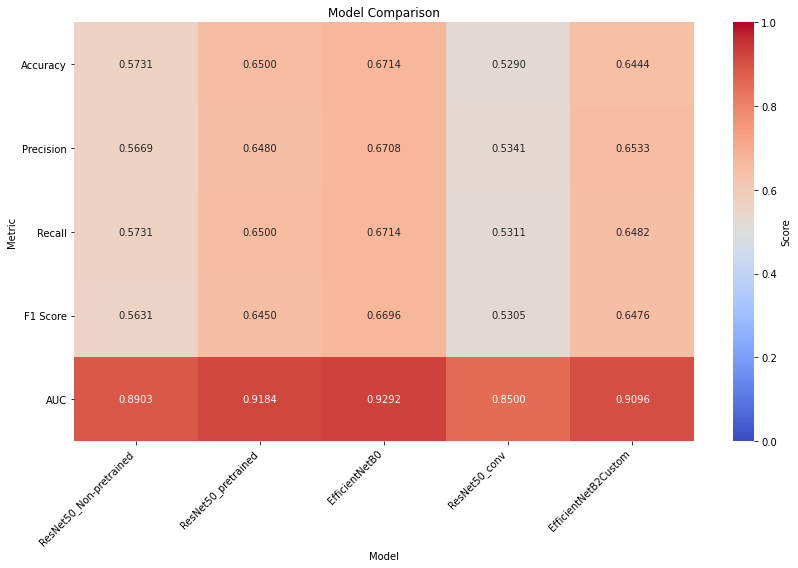

In [66]:
df= pd.DataFrame(all_hyun)   # index=Metric, columns=Model
plt.figure(figsize=(12,8))
sns.heatmap(
    df,
    annot=True,
    fmt='.4f',
    cmap='coolwarm',
    cbar_kws={'label':'Score'},
    vmin=0.0, vmax=1.0
)
plt.title('Model Comparison')
plt.xlabel('Model')    # x축: 모델
plt.ylabel('Metric')   # y축: 지표
plt.xticks(rotation=45, ha='right')  # 모델 이름 기울여서 보기
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [6]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import numpy as np
import json

# ─────────────────────────────────────────────────────────────
# 1) 데이터 증강 & 전처리 파이프라인
# ─────────────────────────────────────────────────────────────
train_transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(512, scale=(0.8,1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])
val_transform = transforms.Compose([
    transforms.Resize(540),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])
seed = 42

# ─────────────────────────────────────────────────────────────
# 2) ImageFolder 로더 + train/val/test 분할
# ─────────────────────────────────────────────────────────────
# data_root = '/home/work/workspace_ai/Artificlass/data_process/data/augmented_images_4'
# full_ds = datasets.ImageFolder(root=data_root, transform=None)
# style2idx = full_ds.class_to_idx.copy()
# num_classes = len(style2idx)

# # 랜덤 인덱스 섞기
# n = len(full_ds)
# indices = np.arange(n)
# np.random.seed(seed)
# np.random.shuffle(indices)
# n_train = int(0.8 * n)
# n_val   = int(0.1 * n)
# train_idx = indices[:n_train]
# val_idx   = indices[n_train:n_train+n_val]
# test_idx  = indices[n_train+n_val:]

# # Subset & DataLoader
# train_ds = Subset(datasets.ImageFolder(root=data_root, transform=train_transform),
#                   train_idx)
# val_ds   = Subset(datasets.ImageFolder(root=data_root, transform=val_transform),
#                   val_idx)
# test_ds  = Subset(datasets.ImageFolder(root=data_root, transform=val_transform),
#                   test_idx)


data_root = '/home/work/workspace_ai/Artificlass/data_process/data/augmented_images_4'
# data_root ='/home/hjjang/Artificlass/data_process/data/augmented_images_4'
train_root='/home/work/workspace_ai/Artificlass/data_process/data/augmented_images_split/train'
val_root='/home/work/workspace_ai/Artificlass/data_process/data/augmented_images_split/val'
full_ds = datasets.ImageFolder(root=train_root, transform=None)
val_full=datasets.ImageFolder(root=val_root, transform=None)
style2idx = full_ds.class_to_idx.copy()
num_classes = len(style2idx)

# 랜덤 인덱스 섞기
n = len(full_ds)
indices = np.arange(n)
np.random.seed(seed)
np.random.shuffle(indices)
# n_train = int(0.8 * n)
n_train=int(n)


# n_val   = int(0.1 * n)
# n_val=int(len(datasets.ImageFolder(root='/home/work/workspace_ai/Artificlass/data_process/data/augmented_images_split/val', transform=None)))
n_v=len(val_full)
indices_v=np.arange(n_v)
np.random.seed(seed)
np.random.shuffle(indices_v)

train_idx = indices[:n_train]
val_idx   = indices_v[:n_val]
test_idx  = indices_v[:n_val]

# Subset & DataLoader
train_ds = Subset(datasets.ImageFolder(root='/home/work/workspace_ai/Artificlass/data_process/data/augmented_images_split/train', transform=train_transform), train_idx)
val_ds   = Subset(datasets.ImageFolder(root='/home/work/workspace_ai/Artificlass/data_process/data/augmented_images_split/val', transform=val_transform), val_idx)
test_ds  = Subset(datasets.ImageFolder(root='/home/work/workspace_ai/Artificlass/data_process/data/augmented_images_split/test', transform=val_transform), val_idx)


loader_kwargs = dict(
    batch_size=16,
    num_workers=4,
    pin_memory=True,
    prefetch_factor=2,
    persistent_workers=True
)
train_loader = DataLoader(train_ds, shuffle=True,  **loader_kwargs)
val_loader   = DataLoader(val_ds,   shuffle=False, **loader_kwargs)
test_loader  = DataLoader(test_ds,  shuffle=False, **loader_kwargs)

In [7]:
with torch.no_grad():
        for imgs_b, lbls_b in val_loader:
            imgs_b, lbls_b = imgs_b.to(device), lbls_b.to(device)
            out = model(imgs_b)
            l   = criterion(out, lbls_b)
            val_loss += l.item() * lbls_b.size(0)
            correct  += (out.argmax(1)==lbls_b).sum().item()
            total_v  += lbls_b.size(0)
        for imgs_c, lbls_c in test_loader:
            imgs_c, lbls_c = imgs_c.to(device), lbls_c.to(device)
            out = model(imgs_c)
            correct_t += (out.argmax(1)==lbls_c).sum().item()
            total_t   += lbls_c.size(0)
    # val_loss /= total_v
    # val_acc   = correct / total_v
    # test_acc  = correct_t / total_t

NameError: name 'device' is not defined

# Learning curve

## Log file

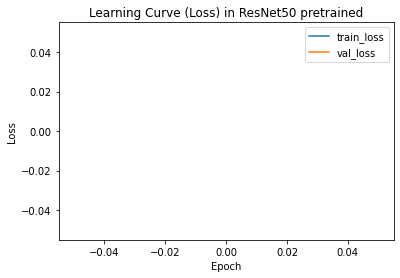

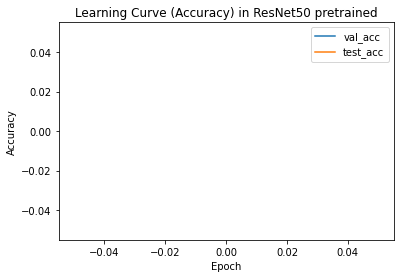

In [16]:
import re
import pandas as pd
import matplotlib.pyplot as plt

# 1) 로그 파일 경로
log_path = '/home/work/workspace_ai/Artificlass/real_use_code/output_log/jpg_resnet50_pre.log'  # 실제 로그 파일 경로로 변경하세요

# 2) 로그 파싱을 위한 정규표현식 패턴
pattern = re.compile(
    r'^\[Epoch\s+(\d+)(?:/\d+)?\]\s+'
    r'train_loss=([\d\.]+)\s+'
    r'val_loss=([\d\.]+)\s+'
    r'val_acc=([\d\.]+)\s+'
    r'test_acc=([\d\.]+)'
)

# 3) 기록 저장용 딕셔너리
records = {'epoch': [], 'train_loss': [], 'val_loss': [], 'val_acc': [], 'test_acc': []}

# 4) 로그 파일 읽어서 매칭된 값 추출
with open(log_path, 'r') as f:
    for line in f:
        m = pattern.match(line.strip())
        if m:
            epoch, tr, vl, va, ta = m.groups()
            records['epoch'].append(int(epoch))
            records['train_loss'].append(float(tr))
            records['val_loss'].append(float(vl))
            records['val_acc'].append(float(va))
            records['test_acc'].append(float(ta))

# 5) DataFrame 생성
df = pd.DataFrame(records)

# 6) 학습 곡선 (Loss)
plt.figure()
plt.plot(df['epoch'], df['train_loss'], label='train_loss')
plt.plot(df['epoch'], df['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve (Loss) in ResNet50 pretrained') 
plt.legend()
plt.show()

# 7) 정확도 곡선 (Accuracy)
plt.figure()
plt.plot(df['epoch'], df['val_acc'], label='val_acc')
plt.plot(df['epoch'], df['test_acc'], label='test_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Learning Curve (Accuracy) in ResNet50 pretrained')
plt.legend()
plt.show()


## From json file

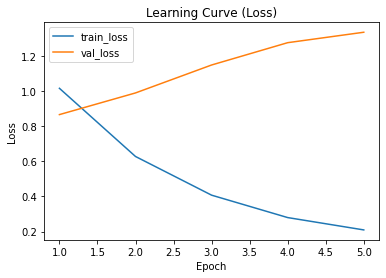

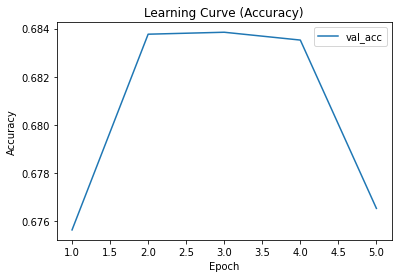

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) JSON metrics 파일 경로 설정
json_path = '/home/work/workspace_ai/Artificlass/weights/Real/history_b2_fixed.json'  # 실제 JSON 파일 경로로 수정하세요

# 2) JSON 로드
df = pd.read_json(json_path)

# 3) 필요한 phase만 선택 (예: 전체 phase)
# df_all = df[df['phase'] == 'all']
df_all=df

# 4) Loss curve 그리기
plt.figure()
plt.plot(df_all['epoch'], df_all['train_loss'], label='train_loss')
plt.plot(df_all['epoch'], df_all['val_loss'],   label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve (Loss)')
plt.legend()
plt.show()

# 5) Accuracy curve 그리기
plt.figure()
plt.plot(df_all['epoch'], df_all['val_acc'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.yscale('log')
plt.title('Learning Curve (Accuracy)')
plt.legend()
plt.show()


# TSNE 

In [72]:

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn
# ─────────────────────────────────────────────────────────────
# 0) EfficientNetB0Head 정의 (기존과 동일)
# ─────────────────────────────────────────────────────────────
class EfficientNetB0Head(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        backbone = models.efficientnet_b0(pretrained=True)
        in_feats = backbone.classifier[1].in_features
        backbone.classifier = nn.Identity()
        self.backbone = backbone

        self.drop  = nn.Dropout(0.2)
        self.fc1   = nn.Linear(in_feats, 512)
        self.relu  = nn.ReLU(inplace=True)
        self.fc2   = nn.Linear(512, 128)
        self.fc3   = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.backbone(x)           
        x = self.drop(x)
        x = self.relu(self.fc1(x))    
        x = self.drop(x)
        x = self.relu(self.fc2(x))    
        x = self.drop(x)
        return self.fc3(x)

# ─────────────────────────────────────────────────────────────
# 1) 데이터 & DataLoader
# ─────────────────────────────────────────────────────────────
root = '/home/work/workspace_ai/Artificlass/data_process/data/augmented_images_split_v2/test'
val_tf = transforms.Compose([
    transforms.Resize(540),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
ds = datasets.ImageFolder(root, transform=val_tf)
loader = DataLoader(ds, batch_size=16, shuffle=False, num_workers=6,
                    pin_memory=True, prefetch_factor=2, persistent_workers=True)

# ─────────────────────────────────────────────────────────────
# 2) 모델 인스턴스 생성 & 가중치 로드
# ─────────────────────────────────────────────────────────────
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = EfficientNetB0Head(num_classes=len(ds.classes)).to(device)
model.load_state_dict(torch.load(
    '/home/work/workspace_ai/Artificlass/weights/Real/best_model_efficientnet_b0_fixed.pth',
    map_location=device))
model.eval()

# ─────────────────────────────────────────────────────────────
# 3) 백본만 쓰도록 분리
# ─────────────────────────────────────────────────────────────
backbone = model.backbone  # <-- 여기!
backbone.eval()

The parameter 'pretrained' is deprecated, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Extracting features: 100%|██████████| 193/193 [00:08<00:00, 23.52it/s]


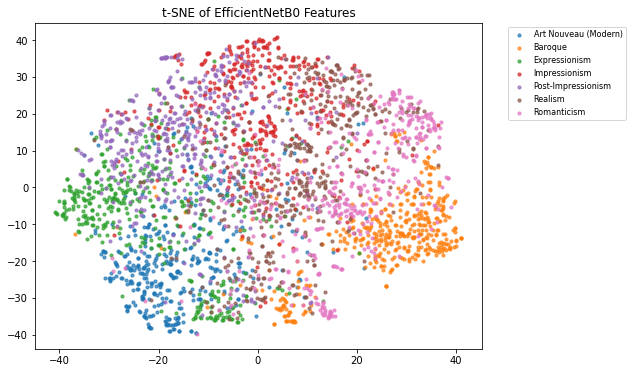

In [76]:
# ─────────────────────────────────────────────────────────────
# 4) 특징 추출
# ─────────────────────────────────────────────────────────────
feats, labels = [], []
with torch.no_grad():
    for imgs, lbl in tqdm(loader, desc="Extracting features"):
        imgs = imgs.to(device, non_blocking=True)
        f = backbone(imgs)          # (batch, feat_dim)
        feats.append(f.cpu().numpy())
        labels.extend(lbl.numpy())

feats = np.vstack(feats)
labels = np.array(labels)

# ─────────────────────────────────────────────────────────────
# 5) t-SNE & 시각화
# ─────────────────────────────────────────────────────────────
emb2d = TSNE(n_components=2, random_state=42, init='pca', learning_rate=20.0).fit_transform(feats)
df = pd.DataFrame({'x': emb2d[:,0], 'y': emb2d[:,1], 'label': labels})
df['class'] = df['label'].map(lambda i: ds.classes[i])

plt.figure(figsize=(8,6))
for cls in df['class'].unique():
    sub = df[df['class']==cls]
    plt.scatter(sub['x'], sub['y'], label=cls, s=10, alpha=0.7)
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize=8)
plt.title('t-SNE of EfficientNetB0 Features')
plt.show()

In [ ]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

# Assume model and test_loader are already defined in the environment
model.eval()

# 1) Feature extraction
features = []
labels = []
with torch.no_grad():
    for imgs, lbls in tqdm(test_loader, desc="Extracting features"):
        imgs = imgs.to(device)
        # Forward up to second-to-last layer
        x = model.backbone(imgs)
        x = model.drop(x)
        x = model.relu(model.fc1(x))
        x = model.drop(x)
        x = model.relu(model.fc2(x))
        # x is of shape [batch, 128]
        features.append(x.cpu().numpy())
        labels.extend(lbls.numpy())

features = np.vstack(features)
labels = np.array(labels)

# 2) t-SNE projection
tsne = TSNE(n_components=2, random_state=42, init='pca')
proj = tsne.fit_transform(features)

# 3) Plot
df_tsne = pd.DataFrame({
    'tsne1': proj[:,0],
    'tsne2': proj[:,1],
    'label': labels
})

plt.figure(figsize=(8,6))
scatter = plt.scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_tsne['label'], cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Class")
plt.title("t-SNE of Test Set Feature Embeddings")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()

# Confusion matrix